In [1]:
from utils.configuration import Editor

with Editor('Config') as Config:

    Config.Model.Backbone.Name = 'Unet'
    Config.Model.Backbone.Encoder = 'efficientnet-b4'
    Config.Model.Head.Name = 'Head_1'
    Config.Model.Head.Param = dict(logit_output=True, in_channels=4)
    Config.Model.LoadWeights = r'D:\Portfolio\Cardiac_Catheterization_Project\pytorch\Logging\EfficientNet\Pretrained\20\weights.pth'
    
    Config.Dataset.ImagesRootPath = r'D:\Dataset_Collection\Cardiac_Catheterization\test\frame_known'
    Config.Dataset.BatchSize = 1
    # control input and output image format
    Config.Dataset.IO.InputRGBImage = False
    Config.Dataset.IO.NumWorkers = 0
    Config.Dataset.IO.PinMemory = False
    Config.Dataset.IO.PrefetchFactor = 2
    Config.Dataset.IO.OutputDtype = 'float'
    # uniformed preprocess
    Config.Dataset.Preprocess.Version = 'v1'

In [2]:
import torch

import Tasks.SimpleSeg.Model.Backbones as Backbones
import Tasks.SimpleSeg.Model.Heads as Heads
from utils import ModelBuilder
from tqdm import tqdm

import Dataset

import Transform.Preprocess


def create_model(Config):
    
    if Config.Model.Backbone.Name == 'Unet':
        backbone_param = dict(encoder_name=Config.Model.Backbone.Encoder, encoder_weights=None, in_channels=1, out_channels=4)

    elif Config.Model.Backbone.Name == 'AttDs':
        assert Config.Model.Backbone.Encoder == None
        backbone_param = dict(in_channels=1, out_channels=4, att_dropout_count=0)

    backbone_class = getattr(Backbones,Config.Model.Backbone.Name)
    head_class = getattr(Heads,Config.Model.Head.Name)
    model = ModelBuilder(
        backbone_class(**backbone_param),
        head_class(**Config.Model.Head.Param))
    
    model.load_state_dict(torch.load(Config.Model.LoadWeights))
    return model
    
def create_dataset(Config):
    preprocess = getattr(Transform.Preprocess,Config.Dataset.Preprocess.Version)
    dataloader = Dataset.FolderLoader(
        root = Config.Dataset.ImagesRootPath,
        batch_size = Config.Dataset.BatchSize,
        image_rgb = Config.Dataset.IO.InputRGBImage,
        preprocess = preprocess,
        dtype = Config.Dataset.IO.OutputDtype,
        num_workers = Config.Dataset.IO.NumWorkers,
        pin_memory = Config.Dataset.IO.PinMemory,
        prefetch_factor = Config.Dataset.IO.PrefetchFactor)
    # dataloader = tqdm(dataloader, position = 0, leave = True)
    return dataloader

2C6749 basal hypo


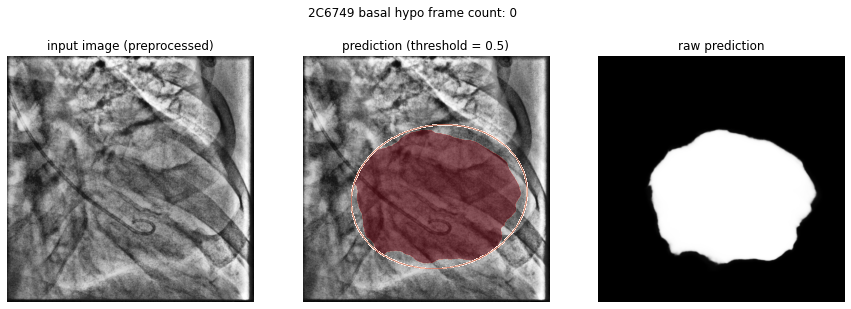

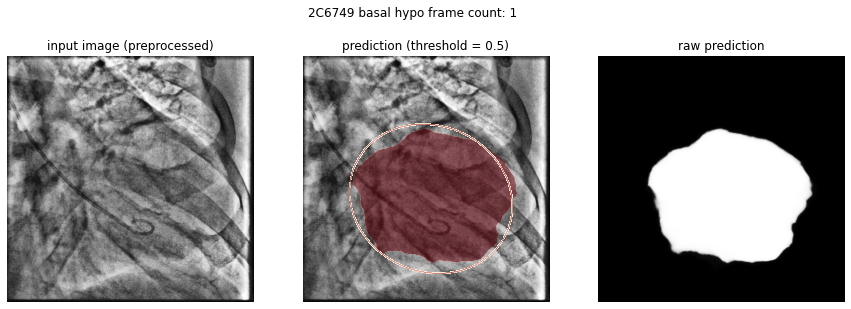

KeyboardInterrupt: 

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = create_model(Config)
dataset = create_dataset(Config)

model = model.to(device)
model = model.eval()

dataset = dataset.to(device)
record = {}

for folder_name, images in dataset:
    print(folder_name)
    frame_count = 0
    record[folder_name] = {}
    
    for batch_image in images:
        predicts = model.predict(batch_image)
        for p,i in zip(predicts,batch_image.squeeze(axis=1)):
            f,ax = plt.subplots(1,3,figsize=(15,5))
            f.suptitle(f'{folder_name} frame count: {frame_count}')
            
            ax[0].set_axis_off()
            ax[0].imshow(i,cmap='gray')
            ax[0].set_title('input image (preprocessed)')
            
            contours,_ = cv2.findContours((p.numpy()*255).astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            contours = max(contours,key=lambda x:len(x))
            # ellipse = cv2.fitEllipse(contours)
            ellipse = cv2.minAreaRect(contours)

            line = np.zeros((512,512),dtype='uint8')
            cv2.ellipse(line, ellipse, color=255)
            
            ax[1].set_axis_off()
            ax[1].imshow(i,cmap='gray')
            ax[1].imshow((p>0.5).type(torch.float32),alpha=(p>0.5).type(torch.float32)*0.5,cmap='Reds')
            ax[1].imshow(line,alpha=line,cmap='Reds')
            ax[1].set_title('prediction (threshold = 0.5)')
            
            ax[2].set_axis_off()
            ax[2].imshow(p,cmap='gray')
            ax[2].set_title('raw prediction')
            
            plt.show()
            
            record[folder_name][frame_count] = {'area':(p>0.5).sum().item(),'long':ellipse[1][0],'short':ellipse[1][1]}
            
            frame_count += 1
    

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = create_model(Config)
dataset = create_dataset(Config)

model = model.to(device)
model = model.eval()

dataset = dataset.to(device)
record = {}

for folder_name, images in dataset:
#     print(folder_name)
    frame_count = 0
    record[folder_name] = {}
    
    for batch_image in images:
        predicts = model.predict(batch_image)
        for p,i in zip(predicts,batch_image.squeeze(axis=1)):
            contours,_ = cv2.findContours((p.numpy()*255).astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            contours = max(contours,key=lambda x:len(x))
            # ellipse = cv2.fitEllipse(contours)
            ellipse = cv2.minAreaRect(contours)
            record[folder_name][frame_count] = {'area':(p>0.5).sum().item(),'long':ellipse[1][0],'short':ellipse[1][1]}
            frame_count += 1

C0086 apical hypo: 100%|█████████████████████████████████████████████████████████████| 176/176 [04:32<00:00,  1.55s/it]


In [4]:
lvef = [(key,pd.DataFrame.from_dict(value,orient='index')) for key,value in record.items()]

In [5]:
for folder_name, table in lvef:
    table['volume'] = table.apply(lambda row: (8*(row['area'])**2)/(3*np.pi*row['long']),axis=1)

In [29]:
for n,f in lvef:
    print(n,f.to_dict())

2C6749 basal hypo {'area': {0: 72283, 1: 69792, 2: 68433, 3: 69050, 4: 73623, 5: 68255, 6: 70373, 7: 68627, 8: 70551, 9: 69576, 10: 68458, 11: 74200, 12: 68477, 13: 70106, 14: 59342, 15: 58687, 16: 65857, 17: 55158, 18: 72001, 19: 70360, 20: 68370, 21: 67233, 22: 65610, 23: 71590, 24: 67625, 25: 72158, 26: 68254, 27: 62695, 28: 62596, 29: 66660, 30: 67101, 31: 51197, 32: 57556, 33: 54834, 34: 58379, 35: 60424, 36: 62185, 37: 60350, 38: 68129, 39: 72756, 40: 68193, 41: 66124, 42: 67848, 43: 65892, 44: 65819, 45: 65687, 46: 64481, 47: 65933, 48: 68584, 49: 64527, 50: 67079, 51: 63024, 52: 65859, 53: 67551, 54: 69399, 55: 67451, 56: 62709, 57: 62581, 58: 59492, 59: 62755, 60: 55800, 61: 55127, 62: 51162, 63: 53426, 64: 52859, 65: 49391, 66: 50493, 67: 50885, 68: 49502, 69: 53070, 70: 54008, 71: 60600, 72: 65959, 73: 71079, 74: 71262, 75: 68281, 76: 67694, 77: 68200, 78: 70660, 79: 66082, 80: 59068, 81: 56516, 82: 53504, 83: 52537, 84: 51676, 85: 56730, 86: 56637, 87: 56858, 88: 60025, 89:

In [6]:
import pathlib
from IPython.display import clear_output

In [7]:
frames = {}
for folder in pathlib.Path(Config.Dataset.ImagesRootPath).iterdir():
    plt.figure(figsize=(15,15))
    plt.axis(False)
    plt.imshow(plt.imread(list(folder.glob('*.jpg'))[0]))
    plt.show()
    diastole, systole = input('diastole, systole:').split(' ')
    frames[folder.name] = {'diastole':int(diastole),'systole':int(systole)}
    clear_output()

In [9]:
frames = pd.DataFrame.from_dict(frames)

In [12]:
frames = frames.T

In [15]:
frames

,diastole,systole
2C6749 basal hypo,113,134
2C6950 apical hypo,40,46
2C6977 normal,44,39
2C7213 (2.3) akinesis,48,43
2C7460 (1.2),72,77
2C7549 5,94,106
2C8145 (4)normal,45,50
C0086 apical hypo,103,114


In [14]:
frames.to_dict()

{'diastole': {'2C6749 basal hypo': 113,
  '2C6950 apical hypo': 40,
  '2C6977 normal': 44,
  '2C7213 (2.3) akinesis': 48,
  '2C7460 (1.2)': 72,
  '2C7549 5': 94,
  '2C8145 (4)normal': 45,
  'C0086 apical hypo': 103},
 'systole': {'2C6749 basal hypo': 134,
  '2C6950 apical hypo': 46,
  '2C6977 normal': 39,
  '2C7213 (2.3) akinesis': 43,
  '2C7460 (1.2)': 77,
  '2C7549 5': 106,
  '2C8145 (4)normal': 50,
  'C0086 apical hypo': 114}}

In [23]:
ans = pd.read_csv(r'D:\Dataset_Collection\Cardiac_Catheterization\backup\LVEF.csv',index_col=0)

ans:37.4,pred:36.31


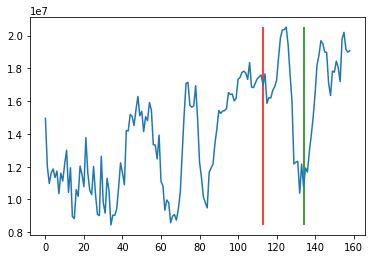

ans:62.4,pred:49.43


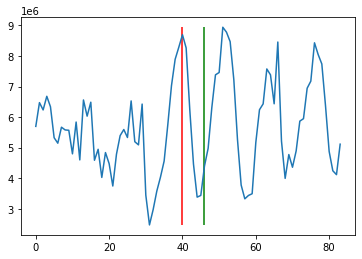

ans:62.3,pred:75.58


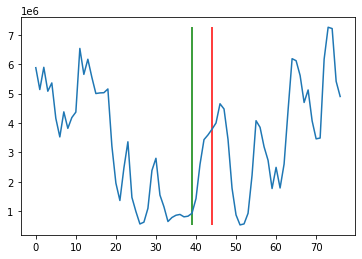

ans:52.5,pred:43.07


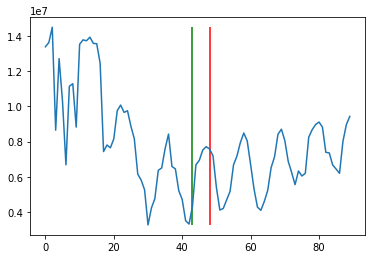

ans:47.1,pred:45.43


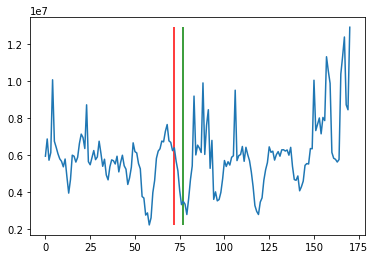

ans:57.7,pred:81.81


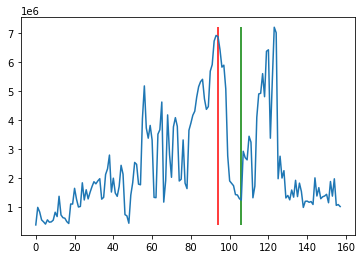

ans:64.3,pred:60.94


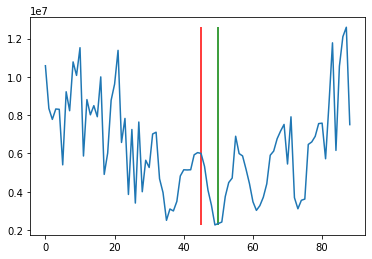

ans:46.4,pred:45.52


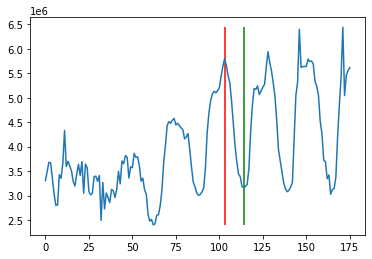

In [27]:
for folder_name, table in lvef:
    a = ans.loc[folder_name]['dodge']
    d,s = frames.loc[folder_name]
    p = (1-table.loc[s,'volume']/table.loc[d,'volume'])*100
    print(f'ans:{a},pred:{p:.2f}')
    table['volume'].plot()
    plt.vlines(d,ymin=table['volume'].min(),ymax=table['volume'].max(),color='r')
    plt.vlines(s,ymin=table['volume'].min(),ymax=table['volume'].max(),color='g')
    plt.show()

In [29]:
edv = d.loc[44]
esv = d.loc[39]

(edv-esv)/edv*100

63.935743587047334